In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")

### EX 6.2

In [3]:
df = pd.read_table("glucose.dat", names=['glucose'])
nrv = stats.norm(loc=df.glucose.mean(), scale=df.glucose.std())
xs = np.linspace(25, 230, num=10000)

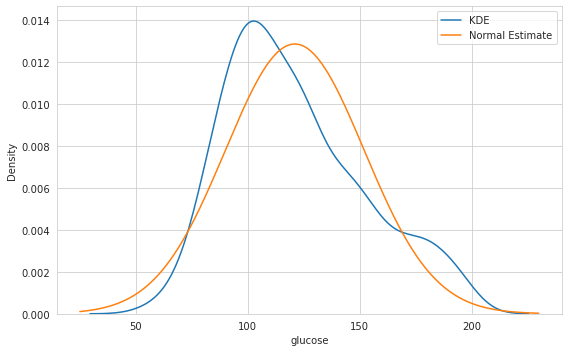

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(df.glucose, label="KDE", ax=ax)
ax.plot(xs, nrv.pdf(xs), label="Normal Estimate")
ax.legend()

fig.tight_layout()
fig.show()

In [130]:
def semi_normal_prec_post(y, prior_var, prior_sample, mean):
    n = y.shape[0]
    post_sample = prior_sample + n
    post_var = 1/post_sample * (prior_var*prior_sample + ((y-mean)**2).sum())

    return post_sample, post_var

def semi_normal_mean_post(y, prior_mean, prior_var, prec):
    n = y.shape[0]
    prior_prec = 1 / prior_var

    post_prec = prior_prec + n * prec
    post_mean = (prior_prec * prior_mean + y.sum() * prec) / post_prec

    return post_mean, 1/post_prec

# np.random.seed(235234)

# observations
Y = df = pd.read_table("glucose.dat", names=['glucose']).glucose
N = Y.shape[0]

# prior parameters
a = b = 1
θ_mean0, θ_var0 = 120, 200
γ_var0, γ_sample0 = 1000, 10

# initization
n_epochs = 10000
samples = []

p = 0.5
θ1, γ1 = Y.mean(), 1/Y.var()
θ2, γ2 = θ1, γ1

for epoch in range(n_epochs):
    Y_p1 = p * stats.norm(loc=θ1, scale=np.sqrt(1/γ1)).pdf(Y)
    Y_p2 = (1-p) * stats.norm(loc=θ2, scale=np.sqrt(1/γ2)).pdf(Y)
    p_N = Y_p1 / (Y_p1 + Y_p2)
    X = np.random.binomial(1, p_N) + 1
    N1, N2 = (X==1).sum(), (X==2).sum()

    p = np.random.beta(a+N1, b+N2)

    γ1_post_sample, γ1_post_var = semi_normal_prec_post(Y[X==1], γ_var0, γ_sample0, θ1)
    γ2_post_sample, γ2_post_var = semi_normal_prec_post(Y[X==2], γ_var0, γ_sample0, θ2)
    γ1 = np.random.gamma(γ1_post_sample/2, 1/(γ1_post_var*γ1_post_sample/2))
    γ2 = np.random.gamma(γ2_post_sample/2, 1/(γ2_post_var*γ2_post_sample/2))

    θ1_post_mean, θ1_post_var = semi_normal_mean_post(Y[X==1], θ_mean0, θ_var0, γ1)
    θ2_post_mean, θ2_post_var = semi_normal_mean_post(Y[X==2], θ_mean0, θ_var0, γ2)
    θ1 = np.random.normal(θ1_post_mean, np.sqrt(θ1_post_var))
    θ2 = np.random.normal(θ2_post_mean, np.sqrt(θ2_post_var))

    # y posterior
    if (np.random.binomial(1, p) + 1) == 1:
        y_post = np.random.normal(θ1, np.sqrt(1/γ1))
    else:
        y_post = np.random.normal(θ2, np.sqrt(1/γ2))

    samples.append((p, θ1, θ2, γ1, γ2, y_post))

S = pd.DataFrame(samples, columns=['p', 'theta_1', 'theta_2', 'gamma_1', 'gamma_2', 'y_post'])

<AxesSubplot:xlabel='y_post', ylabel='Density'>

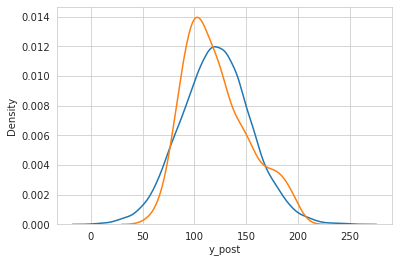

In [153]:
sns.kdeplot(S['y_post'])
sns.kdeplot(Y)

## Ex 6.3

In [377]:
from statsmodels.graphics.tsaplots import plot_acf
import arviz as ar

In [356]:
df = pd.read_fwf("divorce.dat", names=['x', 'y'])
X = df.x.values
Y = df.y.values

In [408]:
var = 1
β_mean0, β_var0 = 0, 16
c_mean0, c_var0 = 0, 16

β = np.random.normal(β_mean0, np.sqrt(β_var0))
c = np.random.normal(c_mean0, np.sqrt(c_var0))
Z = np.random.normal(β*X, np.sqrt(var))

burn_in = 2000
n_epochs = 30000
samples = []
for epoch in range(burn_in + n_epochs):
    # sampling Zs
    bounds = []
    for y in Y:
        if y == 1:
            bounds.append((c, np.inf))
        else:
            bounds.append((-np.inf, c))
    bounds = np.array(bounds)
    
    mu, std = β*X, np.sqrt(var)
    lb = (bounds[:,0] - mu) / std
    ub = (bounds[:,1] - mu) / std

    Z = β*X + np.sqrt(var) * stats.truncnorm(a=lb, b=ub).rvs()

    # sampling c
    c_lb = (Z[Y==0].max() - c_mean0) / np.sqrt(c_var0)
    c_ub = (Z[Y==1].min() - c_mean0) / np.sqrt(c_var0)

    c = c_mean0 + np.sqrt(c_var0) * stats.truncnorm(a=c_lb, b=c_ub).rvs()

    # sampling beta
    β_prec = 1/β_var0 + (X**2).sum()
    β_mean_N = (Z*X).sum()/β_prec

    β = np.random.normal(β_mean_N, np.sqrt(1/β_prec))

    # save
    if epoch < burn_in:
        continue
    else:
        samples.append((epoch, *Z, c, β))

S = pd.DataFrame(samples, columns=['epoch'] + [f'Z_{i}' for i in range(Z.shape[0])] + ['c', 'beta'])

ESS: 1156.48


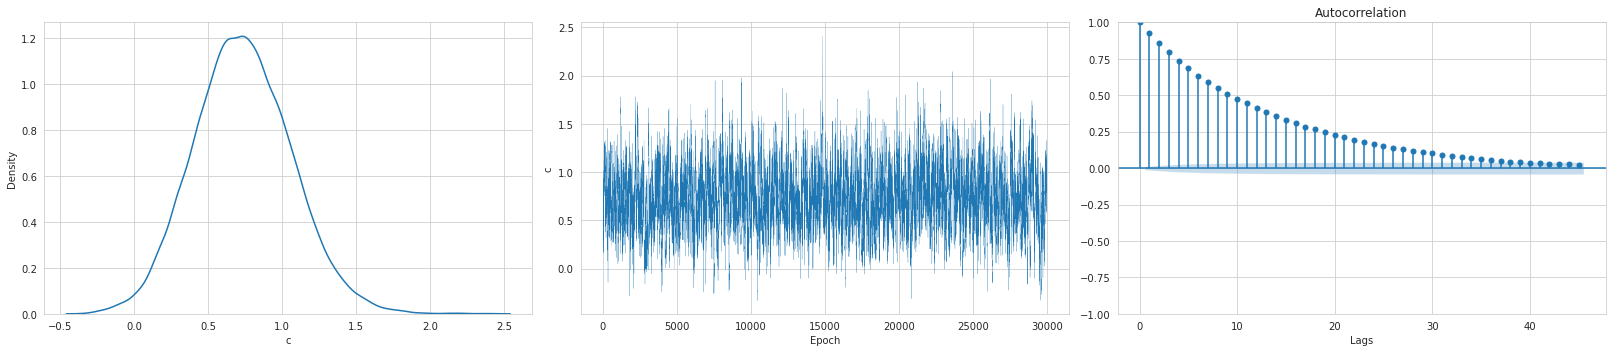

In [436]:
fig, ax = plt.subplots(1, 3, figsize=(7.5*3, 5))
col = 'c'

sns.kdeplot(S[col], ax=ax[0])

S[col].plot(ax=ax[1], linewidth=0.2)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel(col)

plot_acf(S[col], ax=ax[2])
ax[2].set_xlabel('Lags')

fig.tight_layout()
fig.show()

print(f"ESS: {ar.ess(S[col].values):0.2f}")

ESS: 1651.80


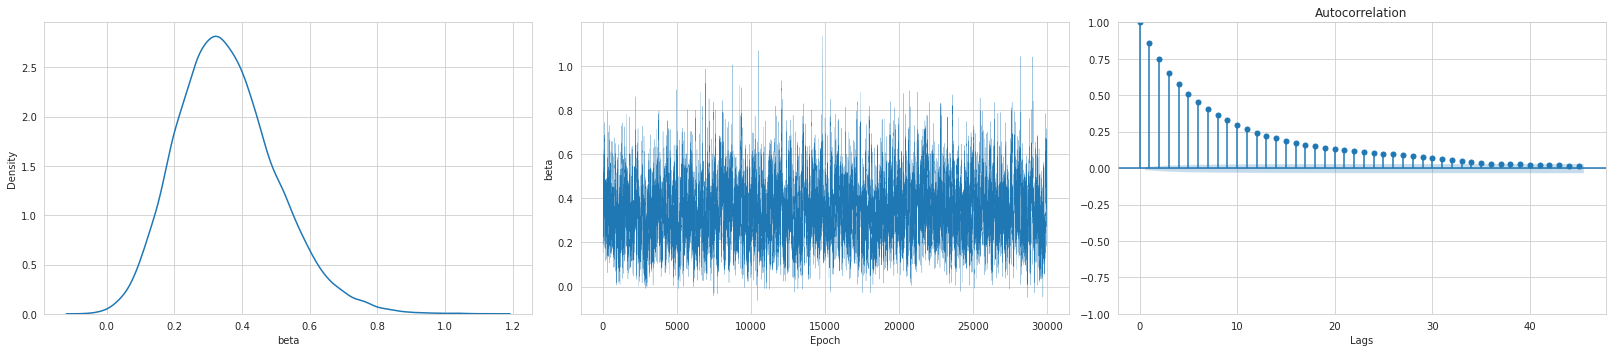

In [438]:
fig, ax = plt.subplots(1, 3, figsize=(7.5*3, 5))
col = 'beta'

sns.kdeplot(S[col], ax=ax[0])

S[col].plot(ax=ax[1], linewidth=0.2)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel(col)

plot_acf(S[col], ax=ax[2])
ax[2].set_xlabel('Lags')

fig.tight_layout()
fig.show()

print(f"ESS: {ar.ess(S[col].values):0.2f}")

In [453]:
S['beta'].quantile([0.025, 0.975])

0.025    0.104173
0.975    0.673902
Name: beta, dtype: float64

In [454]:
(S['beta'] > 0).mean()

0.9991